In [23]:
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import matplotlib
import sys

In [24]:
sys.path.insert(0, '..')

In [25]:
from conv3d_classes import Conv3dModel

Below, dataset is the original dataset, with non-normalized features and containing nan values. dataset_norm has the features normalized and nan values replaced by 0.

In [26]:
dataset = torch.tensor(np.load('../../../numpy_dataset/dataset.npy'))

In [27]:
dataset_norm = torch.tensor(np.load('../../../numpy_dataset/dataset_normalized.npy'))

Below we permute the dataset to in order to be able to feed it into the model, which expects input of shape batch_size x channels x time x height x width

In [28]:
dataset = dataset.permute((0,2,1,3,4))
dataset_norm = dataset_norm.permute((0,2,1,3,4))

The input X consists of the first 11 days of data (the current day preceded by 10 days of lag). The target y consists of the rest of the data (30 days of lead).

In [29]:
X = dataset_norm[:,:,:11]

In [30]:
y = dataset_norm[:,:,11:]

y_un is pulled from dataset and thus contains nan values.

In [31]:
y_un = dataset[:,:,11:]

In [32]:
future_steps = 30

In [33]:
model = Conv3dModel()

In [34]:
model.load_state_dict(torch.load('../best_model_params.pt', map_location=torch.device('cpu')))

<All keys matched successfully>

In [35]:
model.eval()

Conv3dModel(
  (model1): Sequential(
    (0): Conv3d(8, 16, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=same)
    (1): ReLU()
    (2): ResBlock(
      (conv): Conv3d(16, 16, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=same)
      (batch_norm): BatchNorm3d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (3): Dropout(p=0.5, inplace=False)
    (4): ResBlock(
      (conv): Conv3d(16, 16, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=same)
      (batch_norm): BatchNorm3d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (5): Dropout(p=0.5, inplace=False)
    (6): ResBlock(
      (conv): Conv3d(16, 16, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=same)
      (batch_norm): BatchNorm3d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (7): Dropout(p=0.5, inplace=False)
    (8): ResBlock(
      (conv): Conv3d(16, 16, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=same)
      (batch_norm): Ba

In [36]:
test_len = int(len(X) * 0.2)

In [37]:
the_range = list(range(len(X) - test_len, len(X)))

We'll take 20 random samples from the test set and graph the predictions of the model on those 20 random samples.

In [38]:
np.random.seed(42)

In [39]:
sample_indices = np.random.choice(the_range, size=20, replace=False)

In [40]:
sample_indices

array([809, 760, 782, 706, 745, 680, 752, 702, 751, 795, 670, 735, 666,
       717, 675, 681, 794, 755, 749, 667])

In [41]:
sample = X[sample_indices]

In [42]:
y_pred = model(sample).squeeze(2).detach().numpy()

In [50]:
y_true = y[sample_indices,1].numpy()

Below, we mask y_pred and y_true using the nan values in y_un in order to display the predictions sensibly in a pdf.

In [51]:
for_mask = y_un[sample_indices,1]

In [52]:
y_pred = np.ma.masked_where(for_mask.isnan(), y_pred)

In [53]:
y_true = np.ma.masked_where(for_mask.isnan(), y_true)

In [54]:
cmap = plt.get_cmap('Blues')

In [55]:
cmap.set_bad(color='green')

Here we graph the predictions of the model on each of the 20 random test samples. 

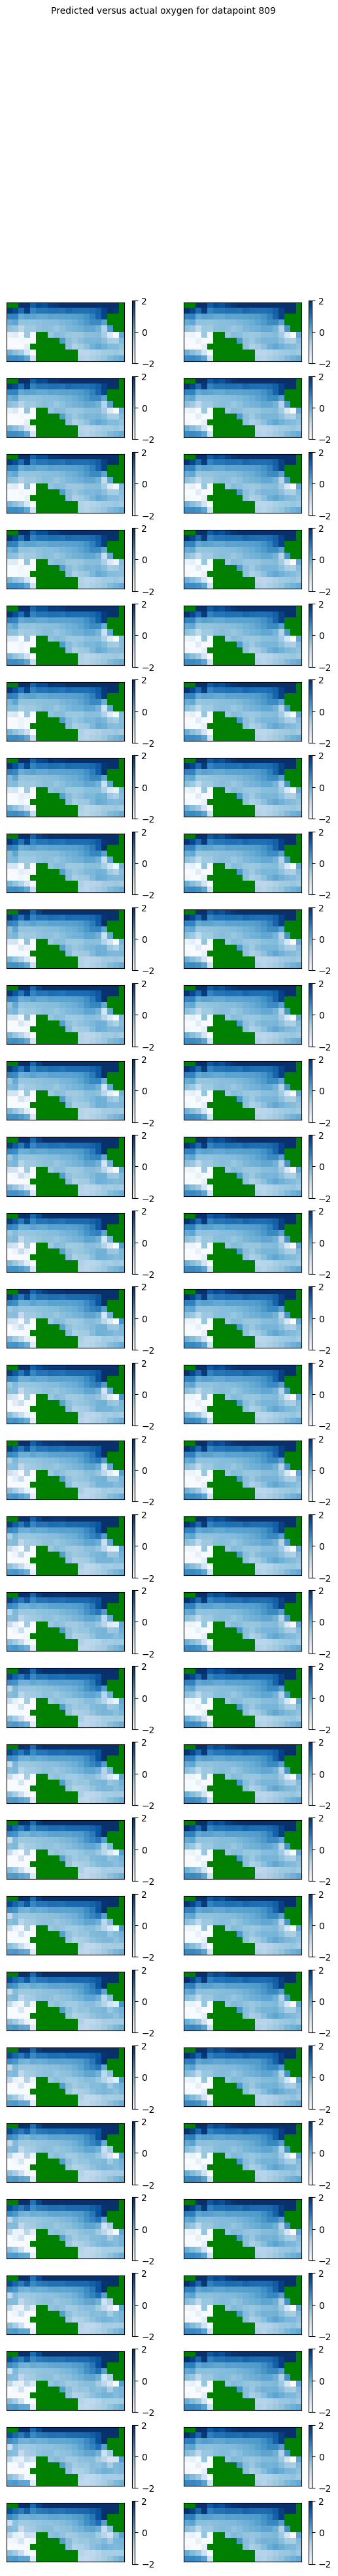

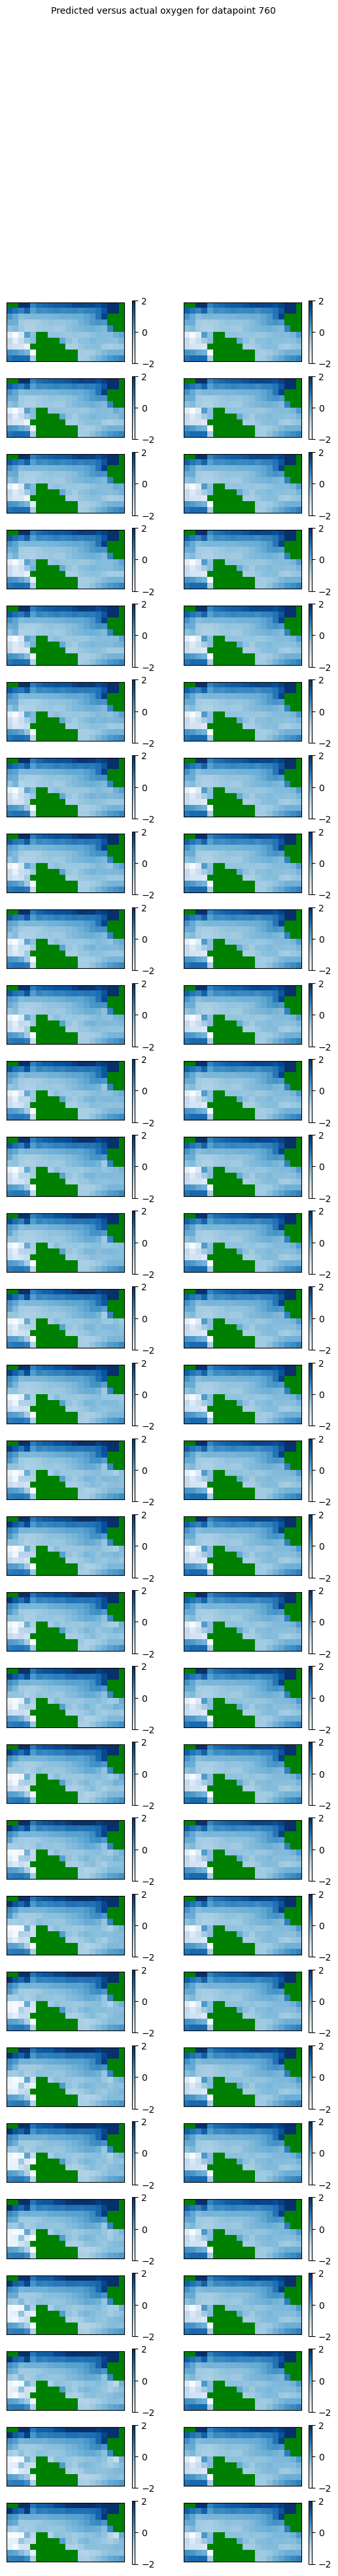

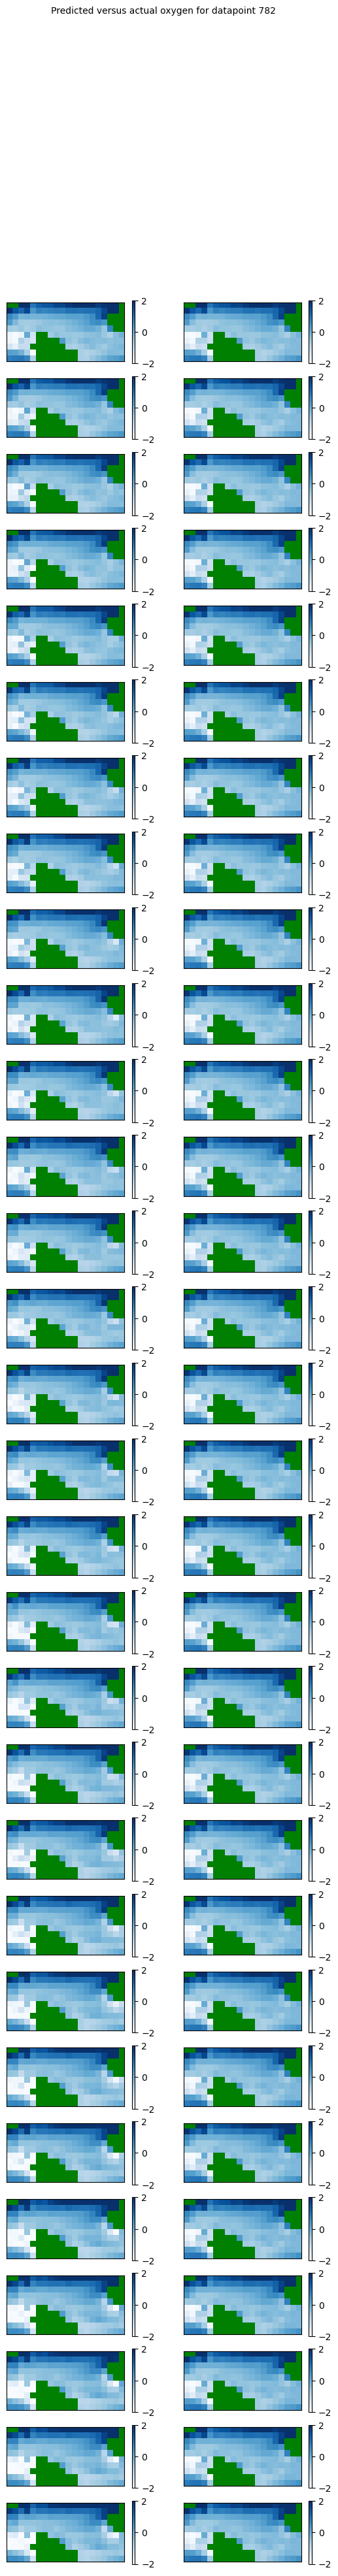

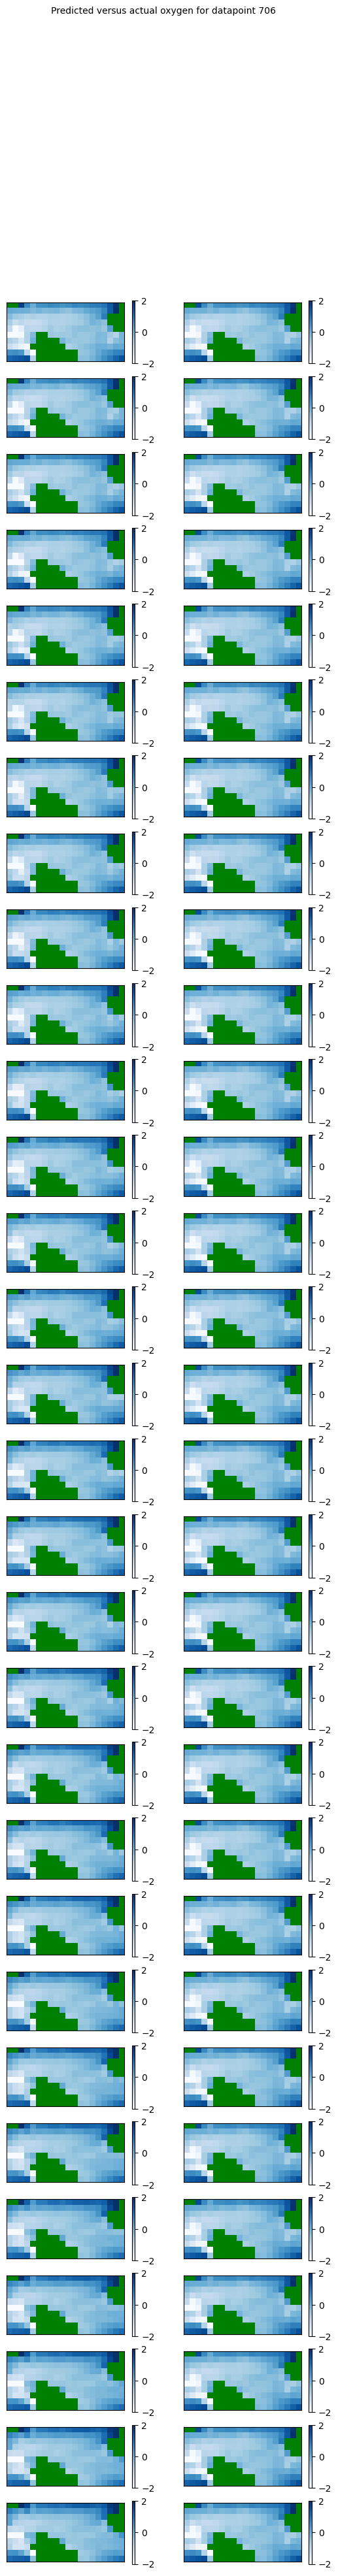

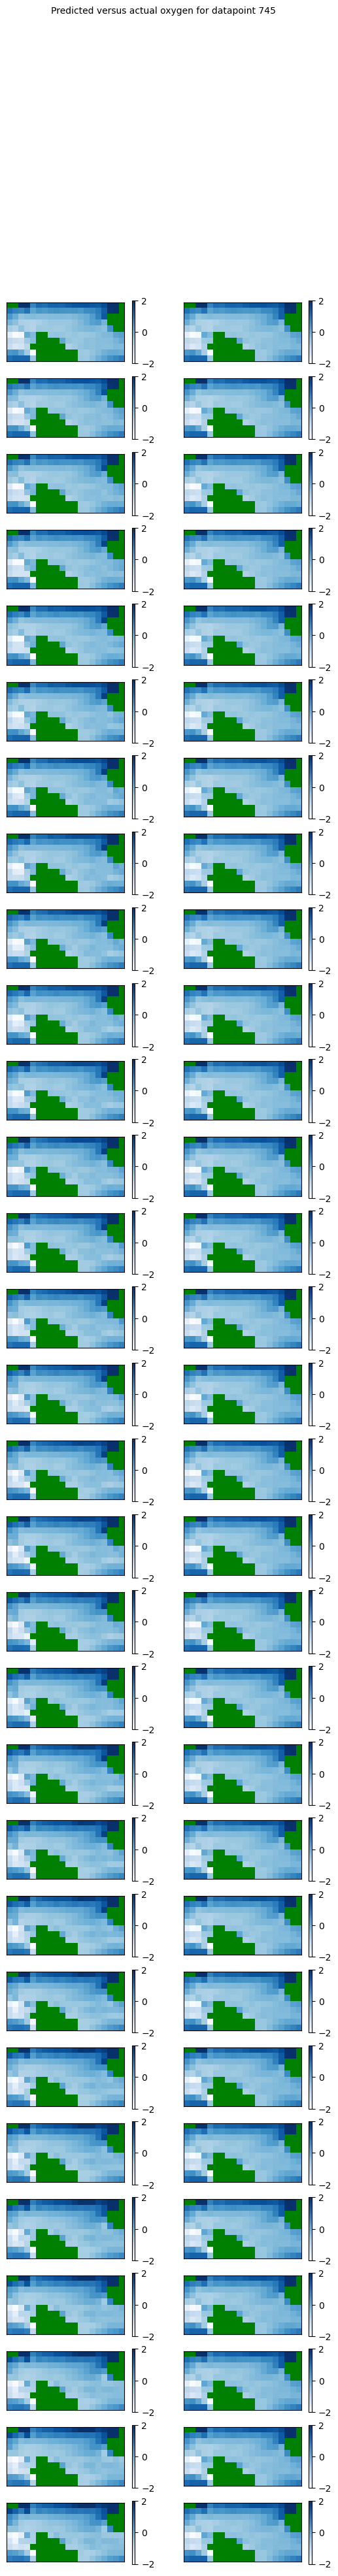

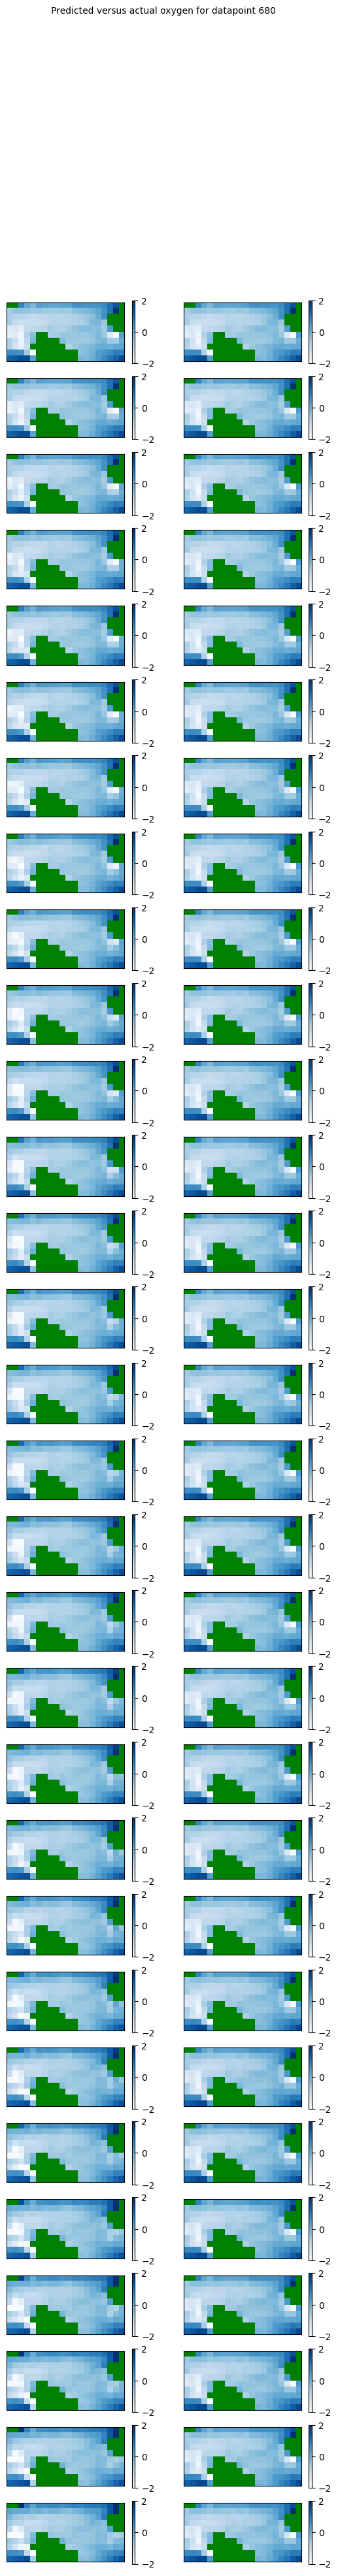

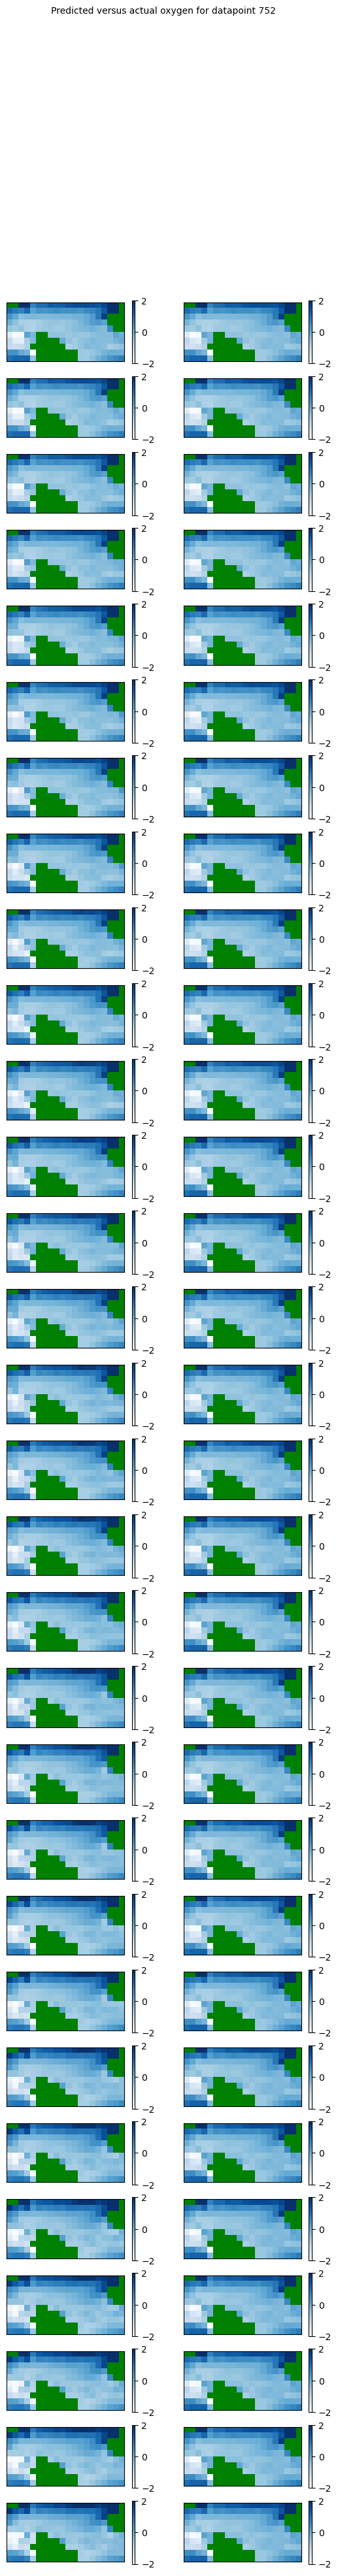

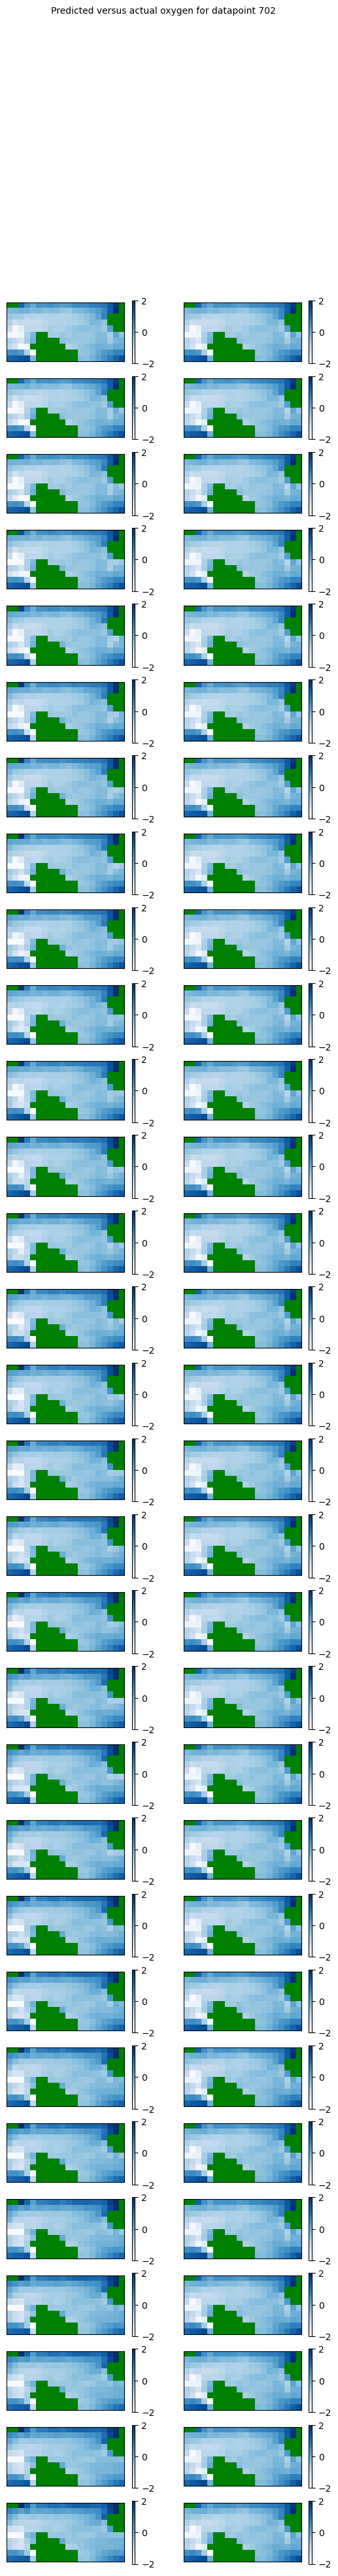

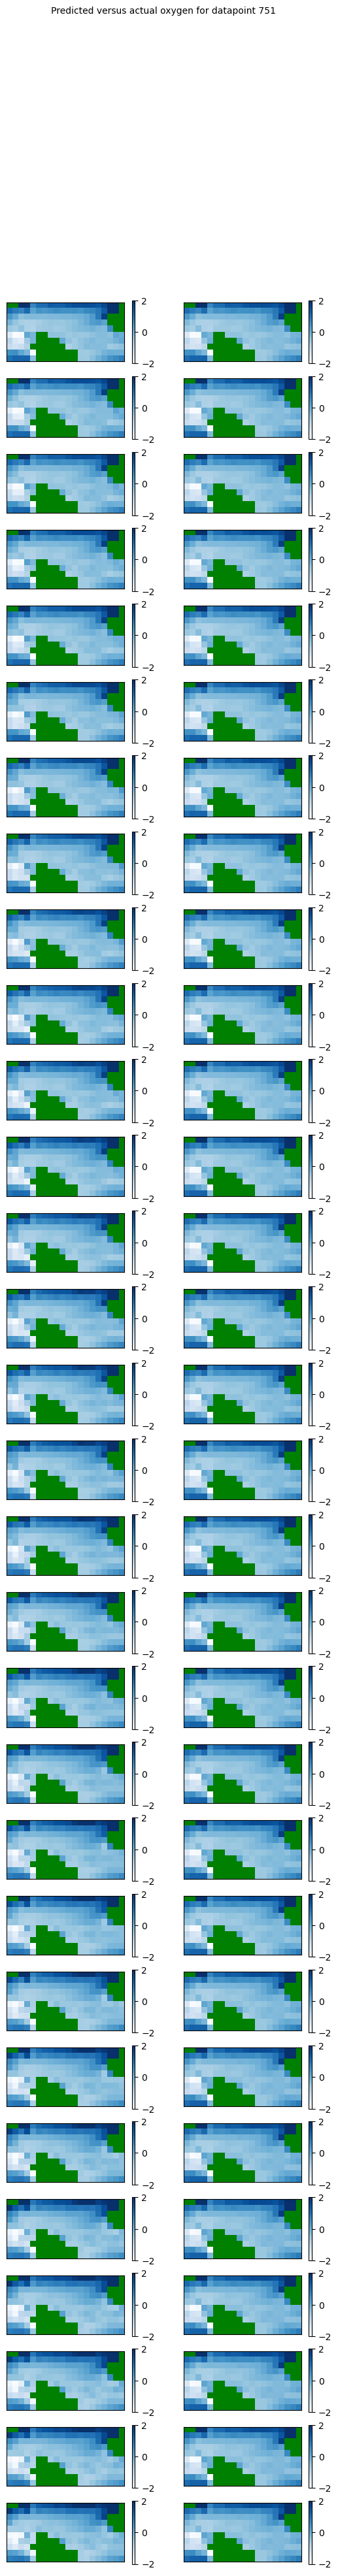

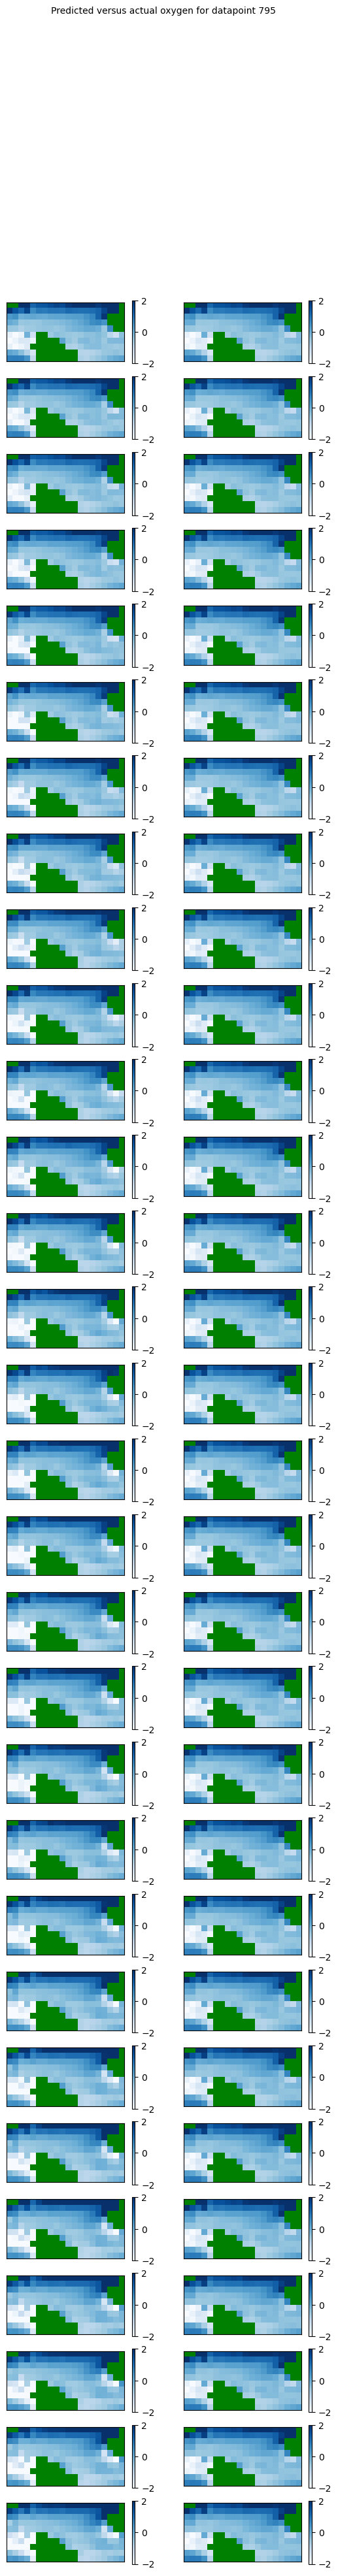

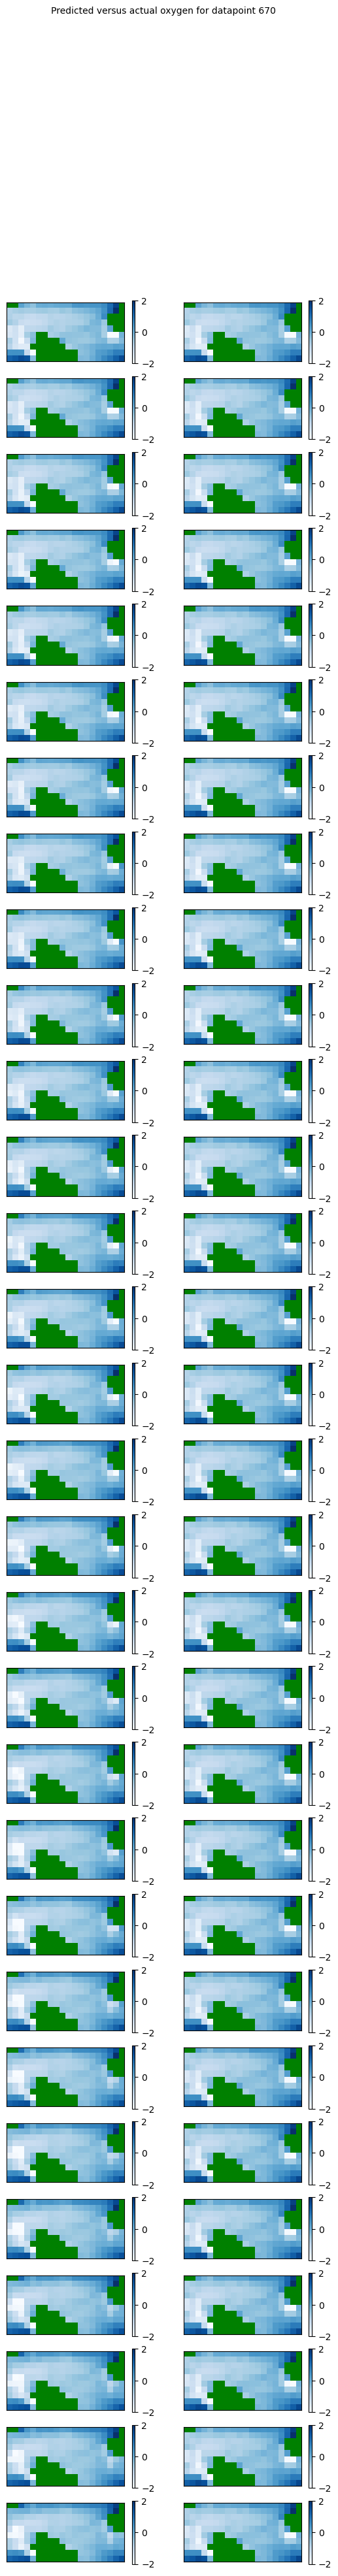

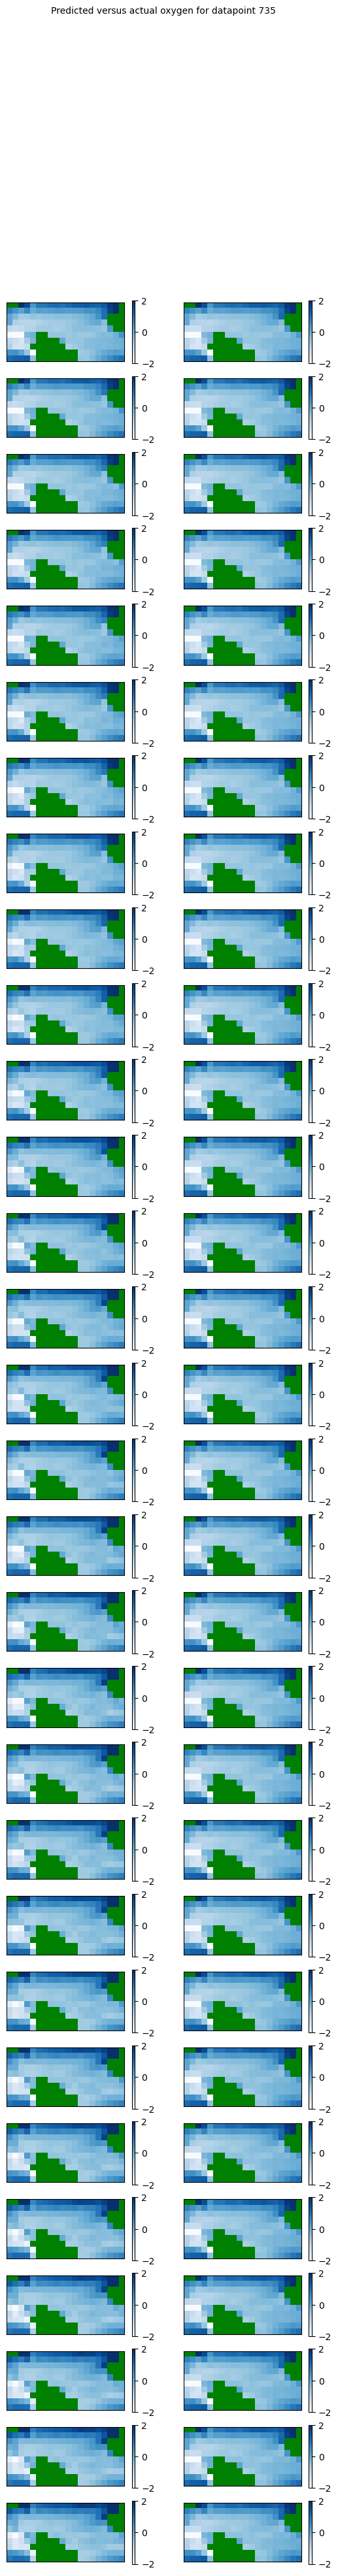

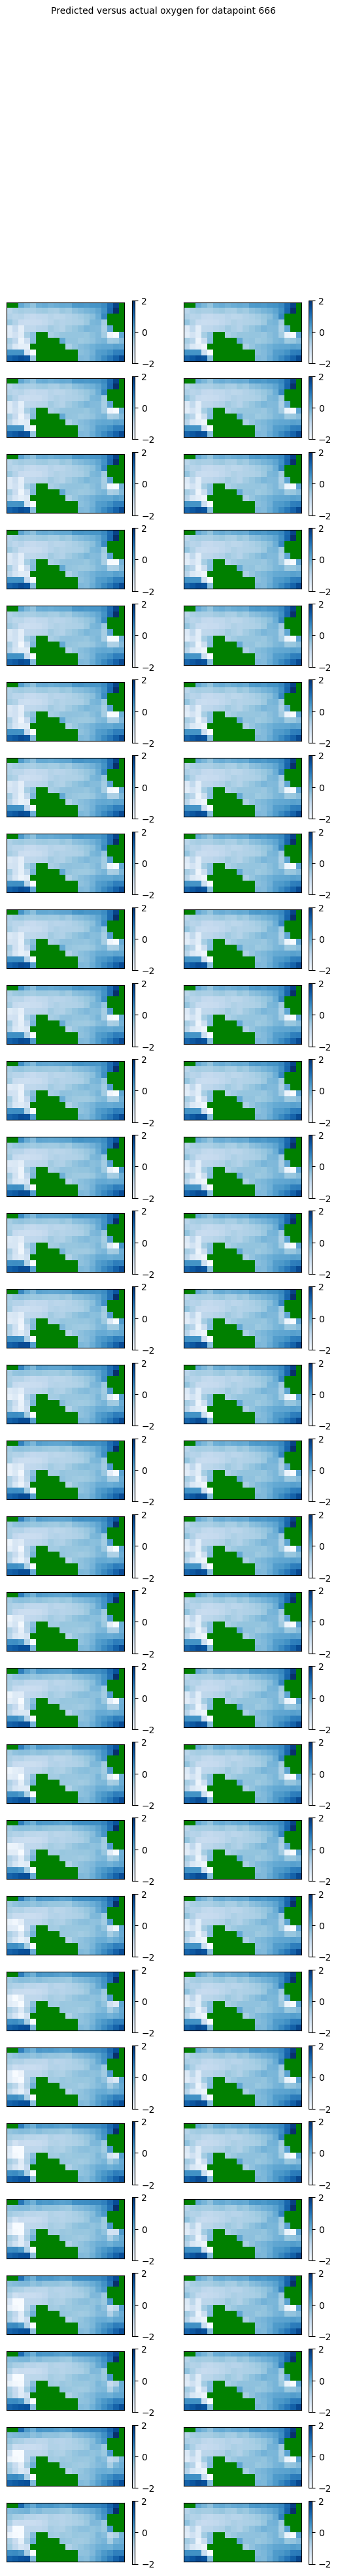

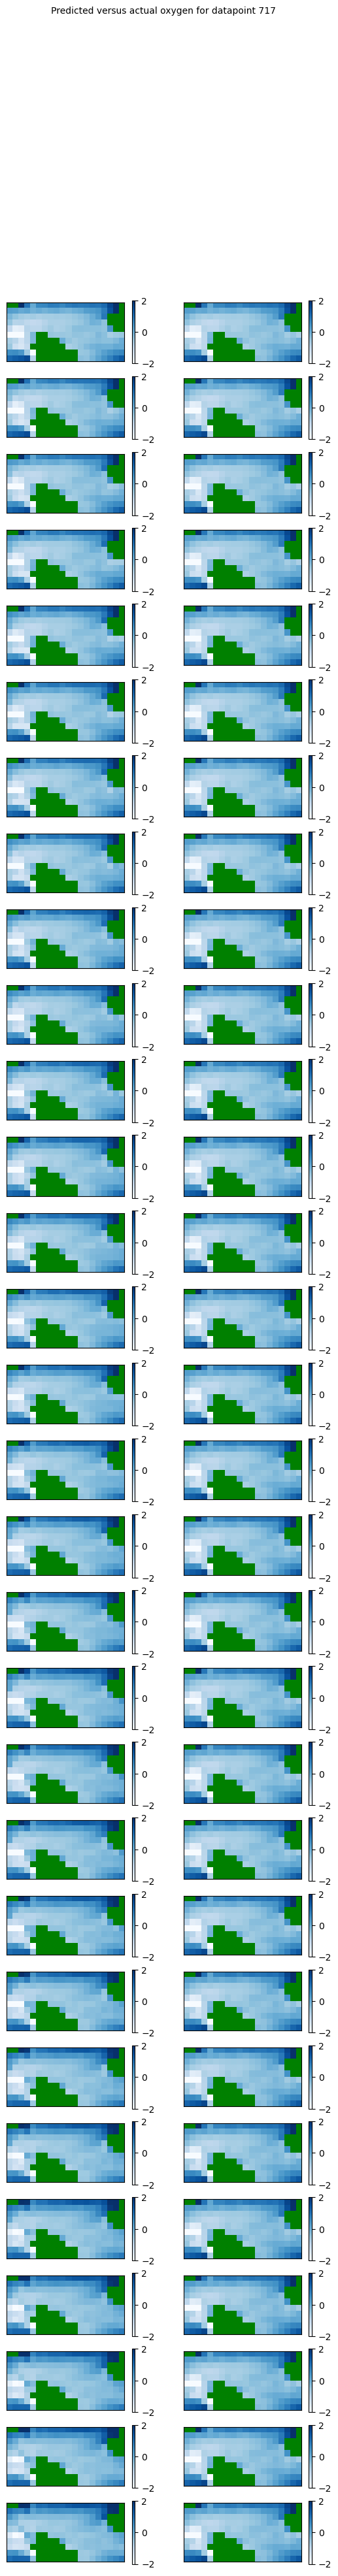

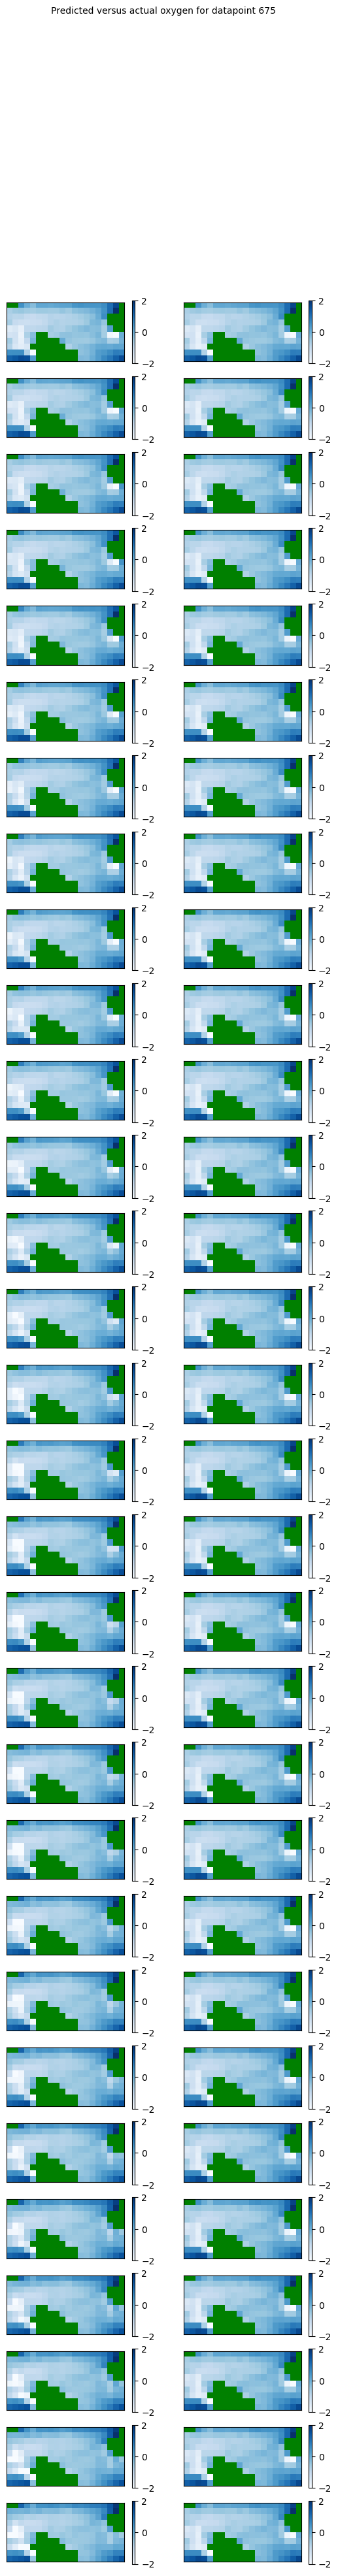

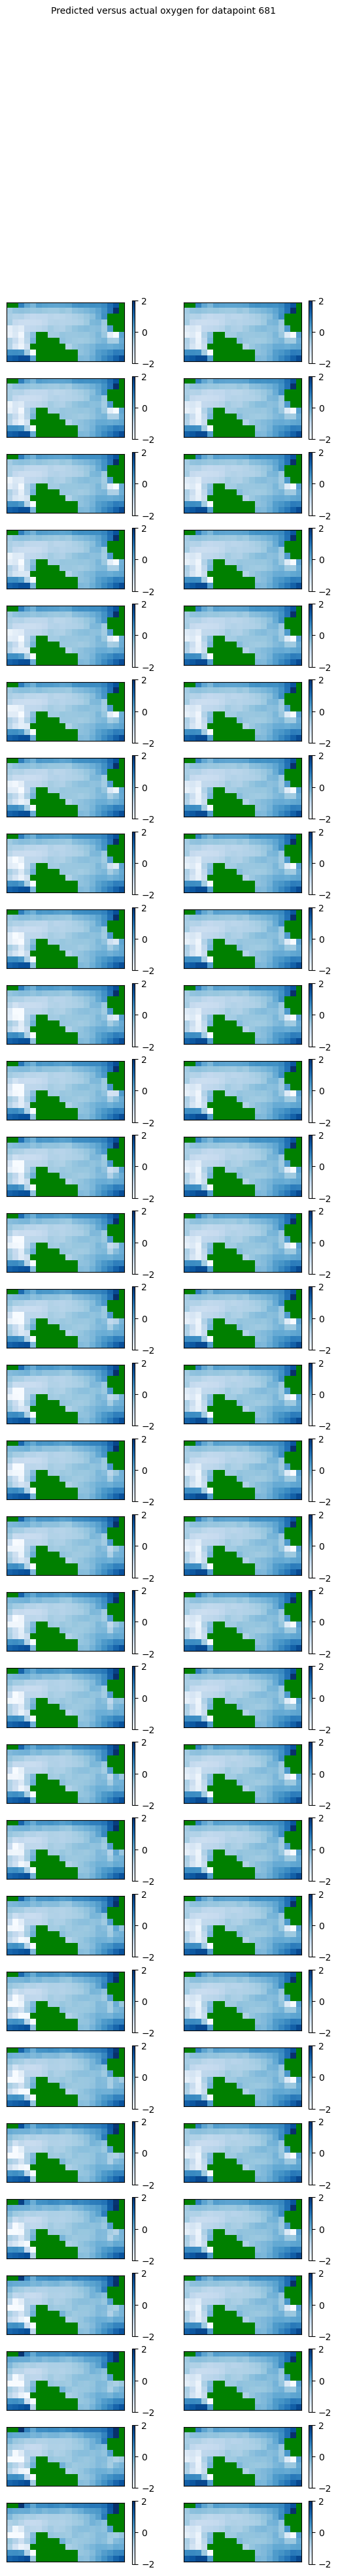

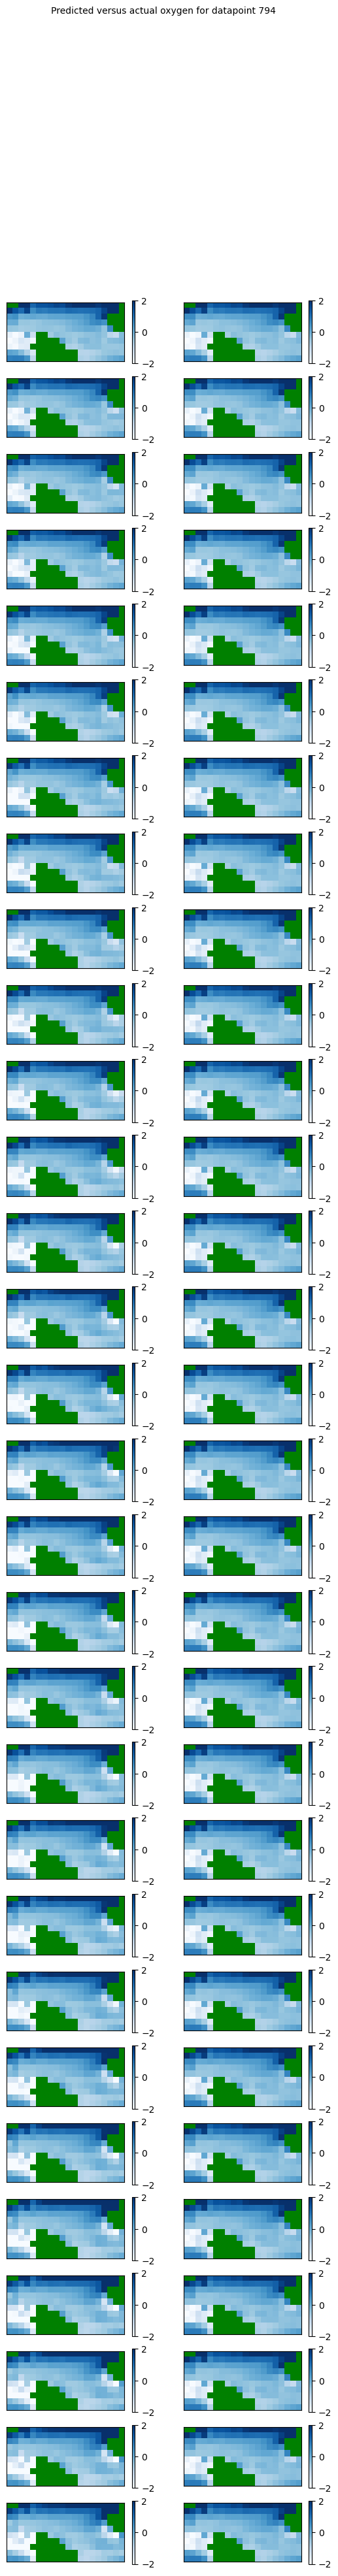

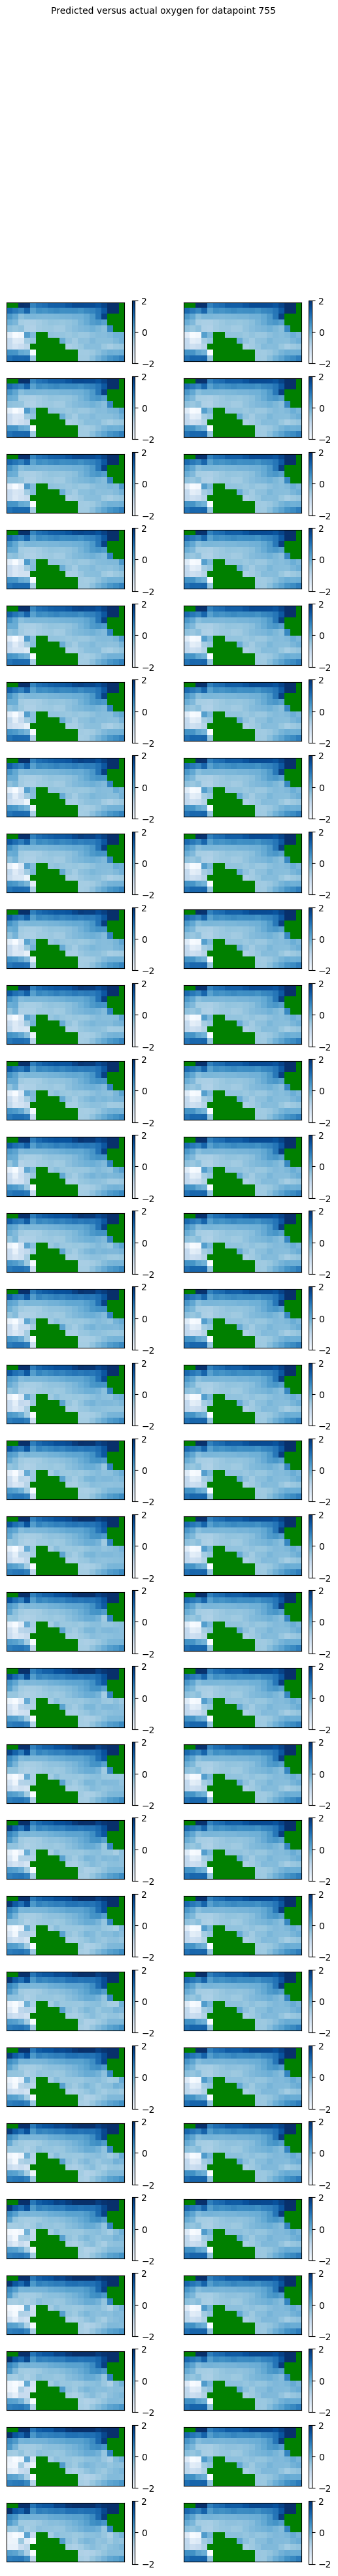

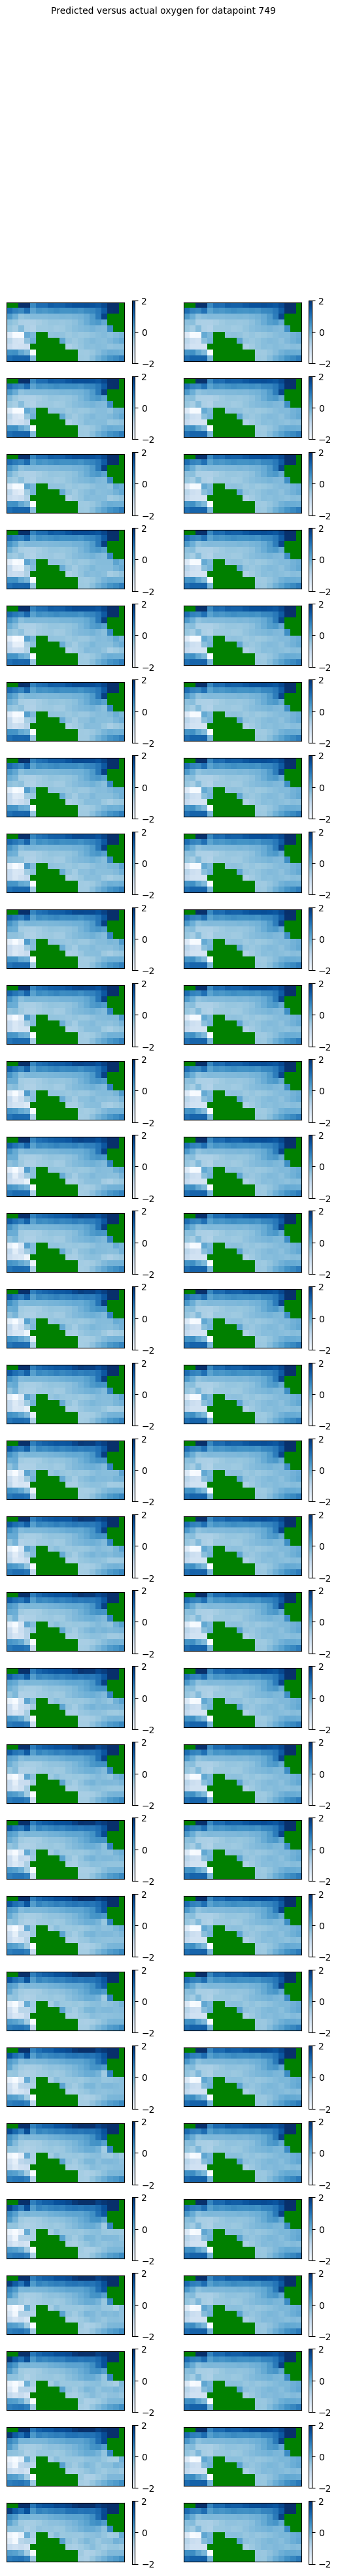

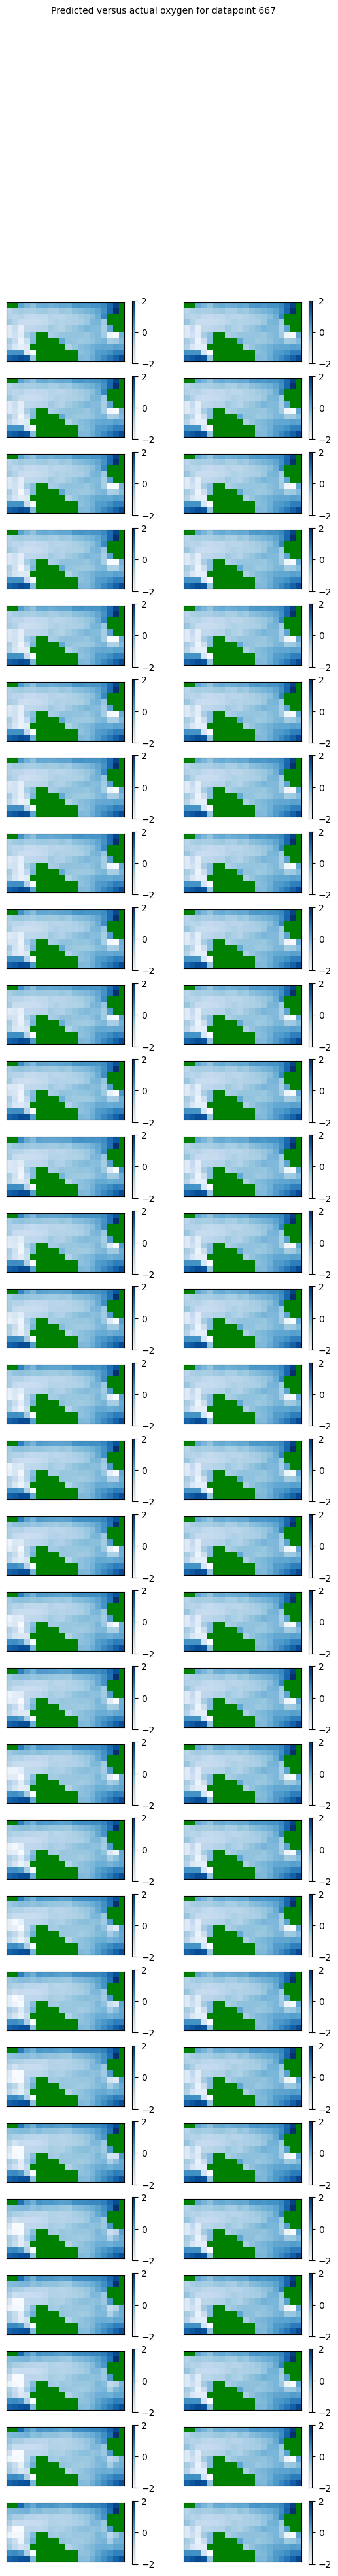

In [56]:
for i, ind in enumerate(sample_indices):
    y_pred_ = y_pred[i]
    y_true_ = y_true[i]

    fig, axes = plt.subplots(30,2)

    fig.set_figheight(45)
    
    fig.suptitle(f'Predicted versus actual oxygen for datapoint {ind}', fontsize=10)
    
    for j in range(30):
        axs = axes[j]
        axs[0].get_xaxis().set_ticks([])
        axs[0].get_yaxis().set_ticks([])
        axs[1].get_xaxis().set_ticks([])
        axs[1].get_yaxis().set_ticks([])
        t = axs[0].imshow(y_true_[j], cmap=cmap, vmin=-2, vmax=2, origin='lower')
        p = axs[1].imshow(y_pred_[j], cmap=cmap, vmin=-2, vmax=2, origin='lower')
        fig.colorbar(t, ax=axs[0], location='right')
        fig.colorbar(p, ax=axs[1], location='right')
    
    plt.savefig(f'graph_point_{ind}.pdf', format='pdf')
    plt.show()